# Bankruptcy Prediction Project
## 1. Data loading and initial exploration

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, accuracy_score, \
    precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import plot_importance, XGBClassifier
import joblib
import os

In [2]:
sns.set_theme(style="whitegrid", context="notebook")
RANDOM_STATE = 42

In [3]:
df = pd.read_csv("./Bankruptcy_data_Final.csv", delimiter=';')

In [4]:
print(f"number of row: {df.shape[0]}")
print(f"number of columns: {df.shape[1]}")

number of row: 92872
number of columns: 15


In [5]:
df.head(10)

,Data Year - Fiscal,Tobin's Q,EPS,Liquidity,Profitability,Productivity,Leverage Ratio,Asset Turnover,Operational Margin,Return on Equity,Market Book Ratio,Assets Growth,Sales Growth,Employee Growth,BK
0,1979,"0,980","1,580","0,360","0,180","0,130","1,330","1,770","0,070","0,150","2,220",NaN,NaN,NaN,0
1,1980,"0,980","1,410","0,360","0,190","0,120","1,310","1,590","0,070","0,130","2,410","0,126","0,014","0,040",0
2,1981,"0,870","0,310","0,320","0,130","0,080","1,030","1,550","0,050","0,040","2,560","0,368","0,328","0,567",0
3,1982,"1,130","0,710","0,280","0,140","0,080","0,800","1,390","0,060","0,050","5,280","-0,021","-0,119","-0,096",0
4,1983,"1,260","0,750","0,410","0,130","0,080","0,200","1,300","0,060","0,040","8,680","0,233","0,147","0,053",0
5,1984,"1,170","1,500","0,370","0,160","0,110","0,340","1,410","0,080","0,080","7,820","0,132","0,232","0,077",0
6,1985,"1,600","1,260","0,360","0,160","0,110","0,600","1,250","0,090","0,050","20,510","0,276","0,133","0,189",0
7,1986,"1,790","1,460","0,370","0,180","0,120","0,360","1,270","0,100","0,050","25,100","0,186","0,202","0,017",0
8,1987,"1,870","1,340","0,370","0,210","0,120","0,480","1,220","0,100","0,050","42,050","0,212","0,166","0,099",0
9,1988,"1,920","1,550","0,360","0,220","0,130","0,560","1,140","0,110","0,050","46,680","0,251","0,169","0,276",0


In [6]:
df.describe()

,Data Year - Fiscal,BK
count,92872.000000,92872.000000
mean,2004.105888,0.006008
std,9.875926,0.077280
min,1979.000000,0.000000
25%,1998.000000,0.000000
50%,2006.000000,0.000000
75%,2012.000000,0.000000
max,2017.000000,1.000000


In [7]:
missing_values = df.isnull().sum().sort_values(ascending=False)

print("number of missing values per column")
missing_values

number of missing values per column


Employee Growth       7010
Assets Growth         6701
Sales Growth          6701
Operational Margin    5557
Tobin's Q              252
Liquidity              247
Profitability          247
Productivity           247
Asset Turnover         247
Market Book Ratio       57
Leverage Ratio          26
Return on Equity         8
EPS                      5
Data Year - Fiscal       0
BK                       0
dtype: int64

In [8]:
missing_percentage = (missing_values / len(df)) * 100
print("percentage of missing values per column")
print(missing_percentage.round(2))

percentage of missing values per column
Employee Growth       7.55
Assets Growth         7.22
Sales Growth          7.22
Operational Margin    5.98
Tobin's Q             0.27
Liquidity             0.27
Profitability         0.27
Productivity          0.27
Asset Turnover        0.27
Market Book Ratio     0.06
Leverage Ratio        0.03
Return on Equity      0.01
EPS                   0.01
Data Year - Fiscal    0.00
BK                    0.00
dtype: float64


In [9]:
print("BK distribution - counts")
df["BK"].value_counts()

BK distribution - counts


BK
0    92314
1      558
Name: count, dtype: int64

In [10]:
print("BK distribution - percentages")
(df["BK"].value_counts(normalize=True) * 100).round(4)

BK distribution - percentages


BK
0    99.3992
1     0.6008
Name: proportion, dtype: float64

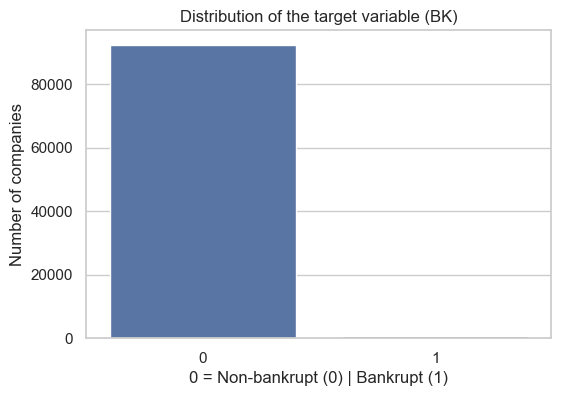

In [11]:
plt.figure(figsize=(6, 4))
sns.countplot(x="BK", data=df)
plt.title("Distribution of the target variable (BK)")
plt.xlabel("0 = Non-bankrupt (0) | Bankrupt (1)")
plt.ylabel("Number of companies")
plt.show()

In [12]:
print("Data types before conversion:")
df.dtypes

Data types before conversion:


Data Year - Fiscal     int64
Tobin's Q             object
EPS                   object
Liquidity             object
Profitability         object
Productivity          object
Leverage Ratio        object
Asset Turnover        object
Operational Margin    object
Return on Equity      object
Market Book Ratio     object
Assets Growth         object
Sales Growth          object
Employee Growth       object
BK                     int64
dtype: object

# 2. Data Preprocessing

### data type

In [13]:
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].str.replace(",", ".", regex=False)

        try:
            df[col] = df[col].astype(float)
        except ValueError:
            print(f"Column '{col}' could not be converted to float and was kept as object.")

In [14]:
df.dtypes

Data Year - Fiscal      int64
Tobin's Q             float64
EPS                   float64
Liquidity             float64
Profitability         float64
Productivity          float64
Leverage Ratio        float64
Asset Turnover        float64
Operational Margin    float64
Return on Equity      float64
Market Book Ratio     float64
Assets Growth         float64
Sales Growth          float64
Employee Growth       float64
BK                      int64
dtype: object

### Duplicates

In [15]:
df.duplicated().sum()

np.int64(35)

In [16]:
df = df.drop_duplicates()

In [17]:
df.duplicated().sum()

np.int64(0)

In [18]:
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns

outlier_summary = {}

In [19]:
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower) | (df[col] > upper)).sum()
    outlier_summary[col] = outliers

In [20]:
print("number of detected outliers per numerical variable")
outlier_summary

number of detected outliers per numerical variable


{'Data Year - Fiscal': np.int64(0),
 "Tobin's Q": np.int64(10652),
 'EPS': np.int64(8384),
 'Liquidity': np.int64(4467),
 'Profitability': np.int64(14150),
 'Productivity': np.int64(13228),
 'Leverage Ratio': np.int64(10341),
 'Asset Turnover': np.int64(3706),
 'Operational Margin': np.int64(15573),
 'Return on Equity': np.int64(13061),
 'Market Book Ratio': np.int64(15997),
 'Assets Growth': np.int64(11973),
 'Sales Growth': np.int64(12418),
 'Employee Growth': np.int64(12677),
 'BK': np.int64(558)}

### Missing values

In [21]:
df = df.fillna(df.median(numeric_only=True))

In [22]:
print("remaining missing values after imputation")
df.isnull().sum().sort_values(ascending=False).head(10)

remaining missing values after imputation


Data Year - Fiscal    0
Tobin's Q             0
EPS                   0
Liquidity             0
Profitability         0
Productivity          0
Leverage Ratio        0
Asset Turnover        0
Operational Margin    0
Return on Equity      0
dtype: int64

# 3. Exploratory Data Analysis

### correlation Heatmap

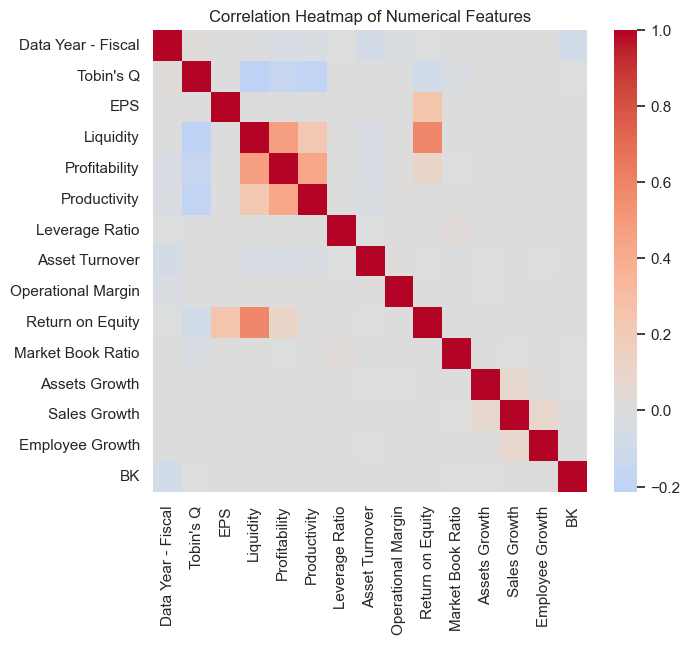

In [23]:
plt.figure(figsize=(7, 6))
corr_matrix = df.corr(method="pearson")
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Numerical Features")
sns.set_style("white")
plt.show()

### Distribution of Numerical Variables

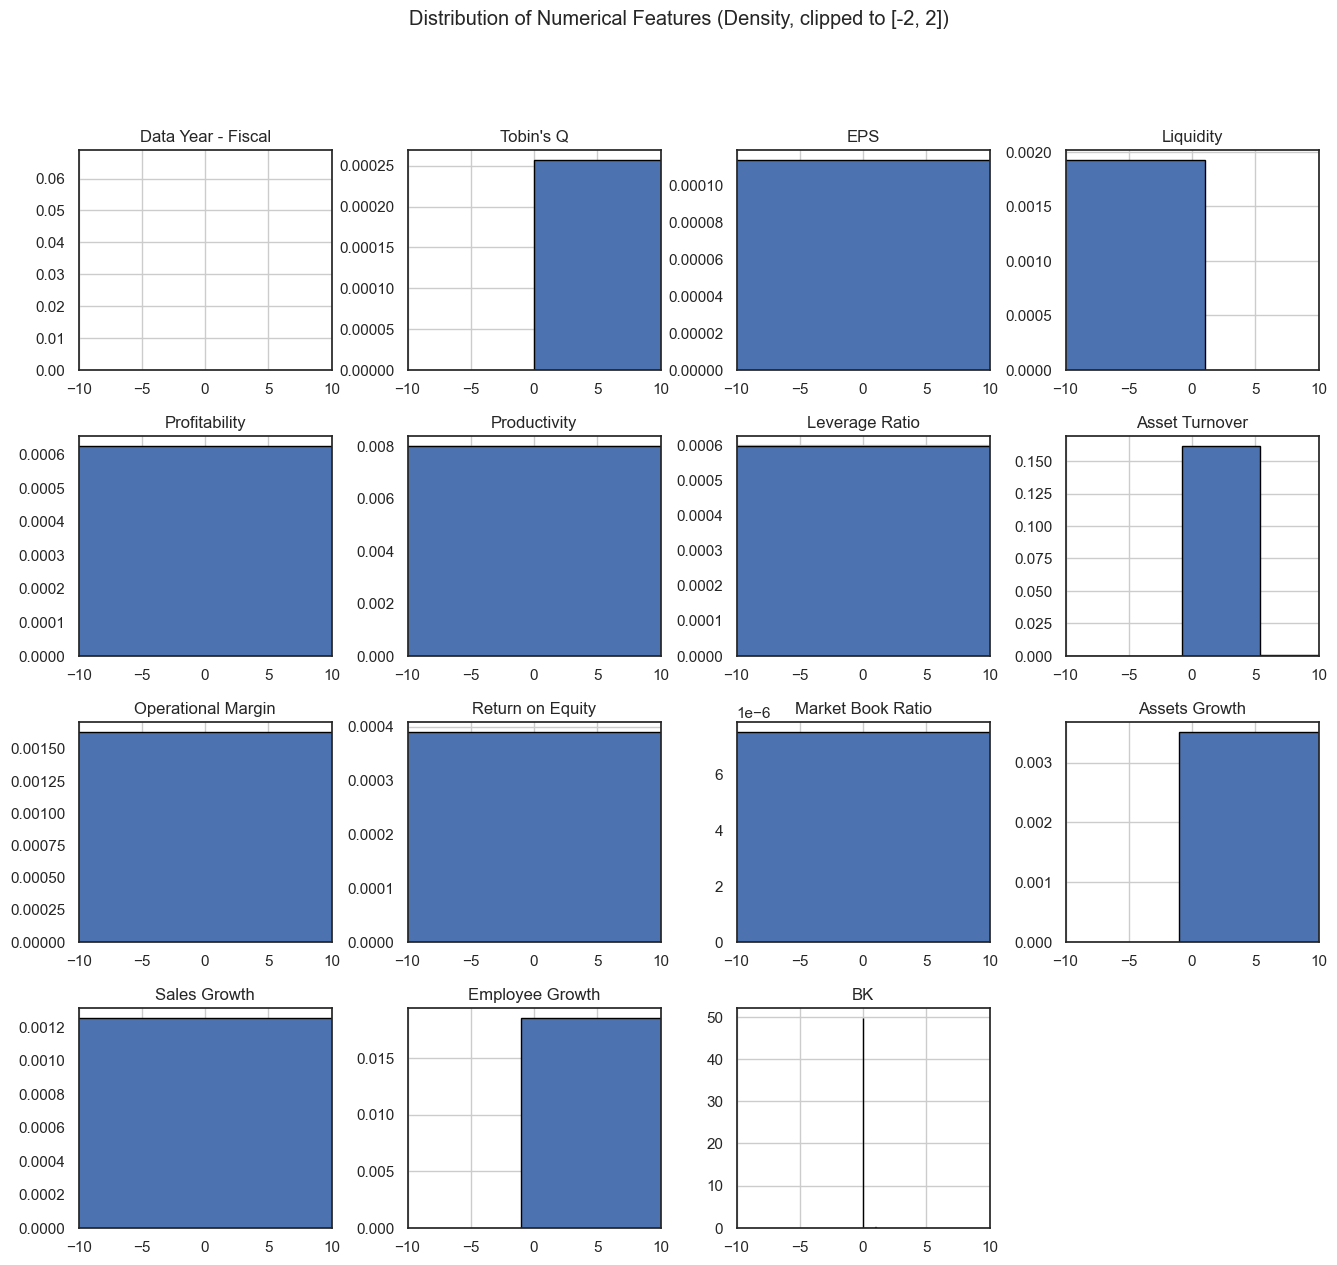

In [24]:
axes = df[numeric_cols].hist(
    figsize=(16, 14),
    bins=50,
    density=True,
    edgecolor="black"
)

for ax in axes.flatten():
    ax.set_xlim(-10, 10)

plt.suptitle("Distribution of Numerical Features (Density, clipped to [-2, 2])")
plt.show()

### Box plots to visualise outliers

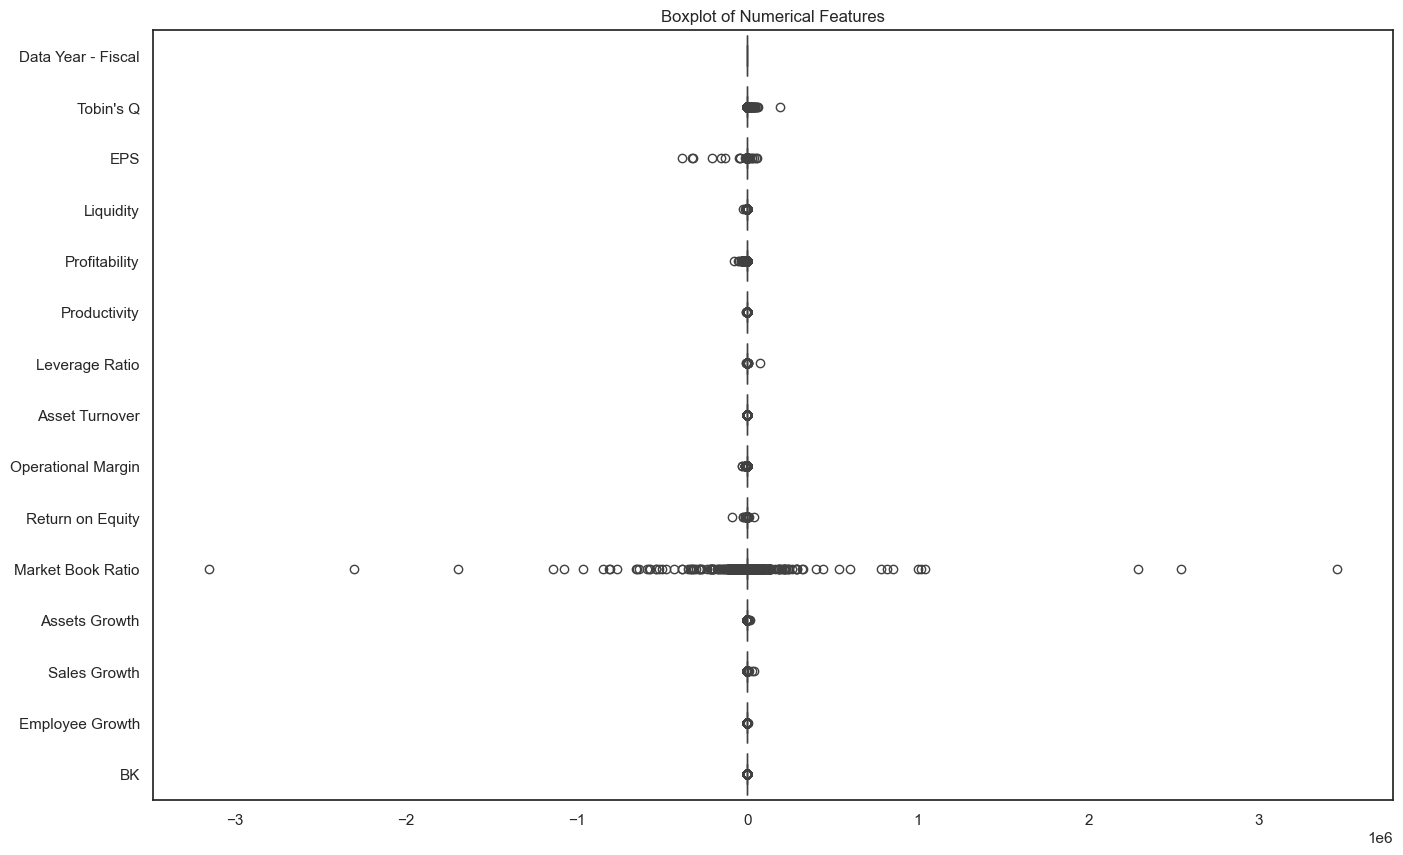

In [25]:
plt.figure(figsize=(16, 10))
sns.boxplot(data=df[numeric_cols], orient="h")
plt.title("Boxplot of Numerical Features")
plt.show()

### Relationship Between Features and BK

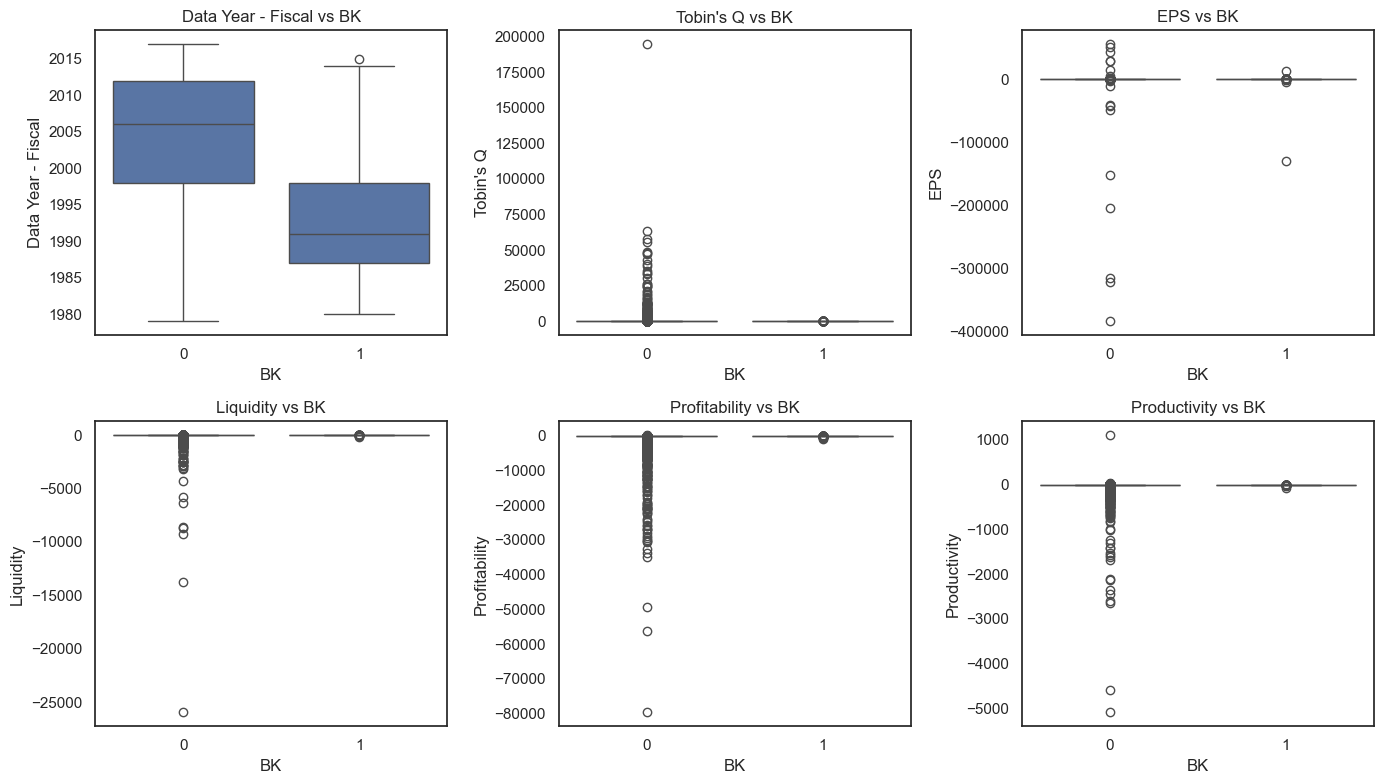

In [26]:
plt.figure(figsize=(14, 8))
for i, col in enumerate(numeric_cols[:6]):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x=df["BK"], y=df[col])
    plt.title(f"{col} vs BK")

plt.tight_layout()
plt.show()

### PCA

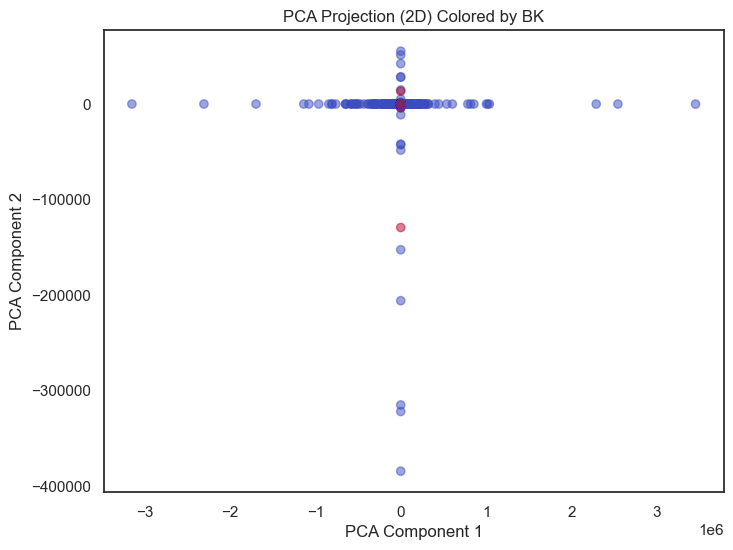

Explained variance ratio: [0.99070179 0.00704493]


In [27]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df.drop(columns=["BK"]))

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df["BK"], cmap="coolwarm", alpha=0.5)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Projection (2D) Colored by BK")
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)

# 4. Train & Test Split, Scaling and Class Imbalance Handling

In [28]:
X = df.drop(columns=["BK"])
y = df["BK"]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=32, stratify=y
)

In [30]:
if os.path.exists("models/scaler.joblib"):
    print("scaler loaded from disk")
    scaler = joblib.load("models/scaler.joblib")
else:
    print("scaler created from scratch")
    scaler = StandardScaler()
    scaler.fit(X_train)
    joblib.dump(scaler, "models/scaler.joblib")

scaler loaded from disk


In [31]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
sm = SMOTE(random_state=RANDOM_STATE)
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

print("before SMOTE :", y_train.value_counts())
print("after SMOTE :", y_train_res.value_counts())

before SMOTE : BK
0    73823
1      446
Name: count, dtype: int64
after SMOTE : BK
0    73823
1    73823
Name: count, dtype: int64


# 5. model training

### Regression logistic

In [33]:
LOGREG_PATH = "models/log_reg.joblib"

if os.path.exists(LOGREG_PATH):
    print("Logistic Regression model found — loading from disk.")
    log_reg = joblib.load(LOGREG_PATH)
else:
    print("Logistic Regression model not found — training and saving.")
    log_reg = LogisticRegression(
        max_iter=500,
        class_weight="balanced",
        random_state=RANDOM_STATE
    )
    log_reg.fit(X_train_res, y_train_res)
    joblib.dump(log_reg, LOGREG_PATH)

Logistic Regression model found — loading from disk.


In [34]:
y_pred_lr = log_reg.predict(X_test_scaled)
y_prob_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

In [35]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       1.00      0.74      0.85     18456
           1       0.02      0.74      0.03       112

    accuracy                           0.74     18568
   macro avg       0.51      0.74      0.44     18568
weighted avg       0.99      0.74      0.84     18568



In [36]:
roc_auc_score(y_test, y_prob_lr)

0.7622622724317296

In [37]:
confusion_matrix(y_test, y_pred_lr)

array([[13583,  4873],
       [   29,    83]])

### Random Forest

In [38]:
RF_PATH = "models/random_forest.joblib"

if os.path.exists(RF_PATH):
    print("Random Forest model found — loading from disk.")
    rf = joblib.load(RF_PATH)
else:
    print("Random Forest model not found — training and saving.")
    rf = RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        random_state=RANDOM_STATE
    )
    rf.fit(X_train_res, y_train_res)
    joblib.dump(rf, RF_PATH)


Random Forest model found — loading from disk.


In [39]:
y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]

In [40]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18456
           1       0.61      0.86      0.71       112

    accuracy                           1.00     18568
   macro avg       0.80      0.93      0.85     18568
weighted avg       1.00      1.00      1.00     18568



In [41]:
roc_auc_score(y_test, y_prob_rf)

0.9945865456065391

### SVM

In [42]:
SVM_PATH = "models/svm_model.joblib"

if os.path.exists(SVM_PATH):
    print("SVM model found — loading from disk.")
    svm_model = joblib.load(SVM_PATH)
else:
    print("SVM model not found — training and saving.")
    svm_model = SVC(
        kernel="rbf",
        probability=True,
        class_weight="balanced",
        C=1,
        gamma="scale",
        random_state=RANDOM_STATE
    )
    svm_model.fit(X_train_res, y_train_res)
    joblib.dump(svm_model, SVM_PATH)


SVM model found — loading from disk.


In [43]:
y_pred_svm = svm_model.predict(X_test_scaled)
y_prob_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

In [44]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       1.00      0.78      0.87     18456
           1       0.02      0.75      0.04       112

    accuracy                           0.78     18568
   macro avg       0.51      0.76      0.46     18568
weighted avg       0.99      0.78      0.87     18568



In [45]:
roc_auc_score(y_test, y_prob_svm)

0.8438457876648711

In [46]:
confusion_matrix(y_test, y_pred_svm)

array([[14327,  4129],
       [   28,    84]])

## XGBoost

In [47]:
scale = (y_train == 0).sum() / (y_train == 1).sum()

In [48]:
XGB_PATH = "models/xgb_model.joblib"

if os.path.exists(XGB_PATH):
    print("XGBoost model found — loading from disk.")
    xgb = joblib.load(XGB_PATH)
else:
    print("XGBoost model not found — training and saving.")
    xgb = XGBClassifier(
        n_estimators=400,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="binary:logistic",
        eval_metric="auc",
        scale_pos_weight=scale,
        random_state=RANDOM_STATE
    )
    xgb.fit(X_train, y_train)
    joblib.dump(xgb, XGB_PATH)

XGBoost model found — loading from disk.


In [49]:
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

In [50]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     18456
           1       0.36      0.89      0.51       112

    accuracy                           0.99     18568
   macro avg       0.68      0.94      0.75     18568
weighted avg       1.00      0.99      0.99     18568



In [51]:
roc_auc_score(y_test, y_prob_xgb)

0.988373893120317

In [52]:
confusion_matrix(y_test, y_pred_xgb)

array([[18279,   177],
       [   12,   100]])

In [53]:
performance = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "SVM", "XGBoost"],
    "ROC AUC": [
        roc_auc_score(y_test, y_prob_lr),
        roc_auc_score(y_test, y_prob_rf),
        roc_auc_score(y_test, y_prob_svm),
        roc_auc_score(y_test, y_prob_xgb)
    ]
})

performance

,Model,ROC AUC
0,Logistic Regression,0.762262
1,Random Forest,0.994587
2,SVM,0.843846
3,XGBoost,0.988374


# 6. Model Evaluation, ROC Curves & Hyperparameter Tuning

### ROC Curves

<Figure size 1000x800 with 0 Axes>

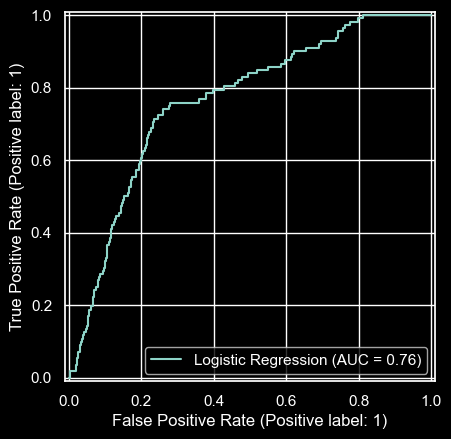

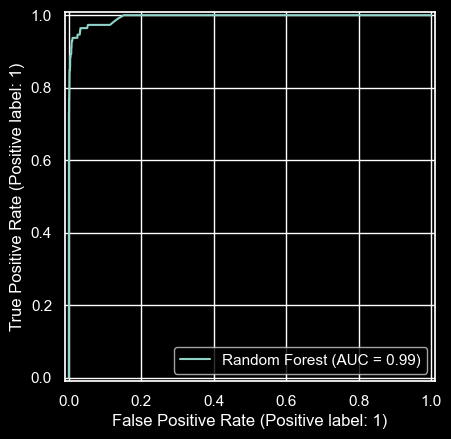

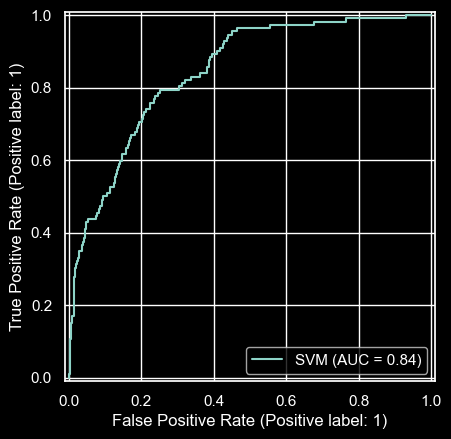

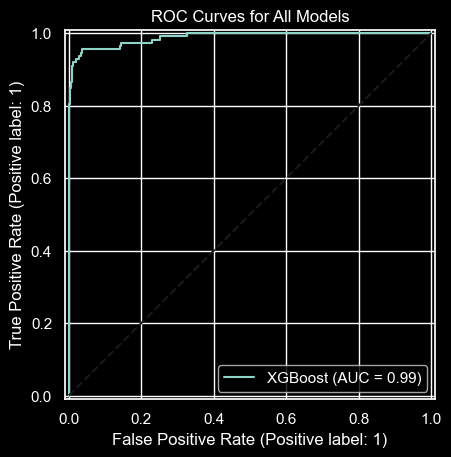

In [54]:
plt.figure(figsize=(10, 8))

models = {
    "Logistic Regression": (y_test, y_prob_lr),
    "Random Forest": (y_test, y_prob_rf),
    "SVM": (y_test, y_prob_svm),
    "XGBoost": (y_test, y_prob_xgb)
}

for name, (yt, yp) in models.items():
    RocCurveDisplay.from_predictions(yt, yp, name=name)

plt.title("ROC Curves for All Models")
plt.plot([0, 1], [0, 1], "k--")
plt.show()

### Extended Metrics Table

In [55]:
def compute_metrics(y_true, y_pred, y_prob):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1-score": f1_score(y_true, y_pred, zero_division=0),
        "ROC AUC": roc_auc_score(y_true, y_prob)
    }

In [56]:
metrics_table = pd.DataFrame([
    compute_metrics(y_test, y_pred_lr, y_prob_lr),
    compute_metrics(y_test, y_pred_rf, y_prob_rf),
    compute_metrics(y_test, y_pred_svm, y_prob_svm),
    compute_metrics(y_test, y_pred_xgb, y_prob_xgb)
], index=["Logistic Regression", "Random Forest", "SVM", "XGBoost"])

metrics_table

,Accuracy,Precision,Recall,F1-score,ROC AUC
Logistic Regression,0.735997,0.016747,0.741071,0.032755,0.762262
Random Forest,0.995799,0.607595,0.857143,0.711111,0.994587
SVM,0.776120,0.019938,0.750000,0.038844,0.843846
XGBoost,0.989821,0.361011,0.892857,0.514139,0.988374


### Hyperparameter Tuning

In [57]:
N_ITER = 5  # nombre de param test
N_CV = 3  # nombre de folds
N_JOB = 4  # nombre de cœurs que le pc va utiliser

In [58]:
rf_params = {
    "n_estimators": [200, 300, 500, 800],
    "max_depth": [None, 10, 20, 40],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}

In [59]:
RF_PARAMS_PATH = "models/rf_best_params.joblib"

if os.path.exists(RF_PARAMS_PATH):
    print("Random Forest best parameters found — loading from disk.")
    rf_best_params = joblib.load(RF_PARAMS_PATH)
else:
    print("Random Forest best parameters not found — running RandomizedSearchCV.")

    rf_random = RandomizedSearchCV(
        estimator=RandomForestClassifier(
            class_weight="balanced",
            random_state=RANDOM_STATE
        ),
        param_distributions=rf_params,
        n_iter=N_ITER,
        cv=N_CV,
        scoring="roc_auc",
        random_state=RANDOM_STATE,
        n_jobs=N_JOB
    )

    rf_random.fit(X_train_res, y_train_res)
    rf_best_params = rf_random.best_params_

    joblib.dump(rf_best_params, RF_PARAMS_PATH)

Random Forest best parameters found — loading from disk.


In [60]:
print("best parameters for Random Forest = ", rf_best_params)

best parameters for Random Forest =  {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None}


### Hyperparameter Tuning – SVM

In [61]:
svm_params = {
    "C": [0.1, 1, 10, 50],
    "gamma": ["scale", 0.1, 0.01, 0.001],
    "kernel": ["rbf"]
}

In [62]:
# for this model we use specific parameters because it consumes a lot and is long
SVM_PARAMS_PATH = "models/svm_best_params.joblib"

if os.path.exists(SVM_PARAMS_PATH):
    print("Optimized SVM found — loading best parameters.")
    svm_best_params = joblib.load(SVM_PARAMS_PATH)

else:
    print("Optimized SVM not found — running RandomizedSearchCV.")

    svm_random = RandomizedSearchCV(
        estimator=SVC(
            class_weight="balanced",
            probability=True,
            random_state=RANDOM_STATE
        ),
        param_distributions=svm_params,
        n_iter=3,
        cv=2,
        scoring="roc_auc",
        random_state=RANDOM_STATE,
        n_jobs=N_JOB
    )

    svm_random.fit(X_train_res, y_train_res)

    svm_best_params = svm_random.best_params_

    joblib.dump(svm_best_params, SVM_PARAMS_PATH)

Optimized SVM found — loading best parameters.


In [63]:
print("best parameters for SVM = ", svm_best_params)

best parameters for SVM =  {'kernel': 'rbf', 'gamma': 0.1, 'C': 1}


### hyperparameter Tuning – XGBoost

In [64]:
xgb_params = {
    "n_estimators": [200, 400, 600],
    "max_depth": [3, 4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.3]
}

In [65]:
XGB_PARAMS_PATH = "models/xgb_best_params.joblib"

if os.path.exists(XGB_PARAMS_PATH):
    print("Optimized XGBoost found — loading best parameters.")
    xgb_best_params = joblib.load(XGB_PARAMS_PATH)

else:
    print("Optimized XGBoost not found — running RandomizedSearchCV.")

    xgb_random = RandomizedSearchCV(
        estimator=XGBClassifier(
            scale_pos_weight=scale,
            objective="binary:logistic",
            eval_metric="auc",
            random_state=RANDOM_STATE
        ),
        param_distributions=xgb_params,
        n_iter=N_ITER,
        cv=N_CV,
        scoring="roc_auc",
        random_state=RANDOM_STATE,
        n_jobs=N_JOB
    )

    xgb_random.fit(X_train, y_train)

    xgb_best_params = xgb_random.best_params_

    joblib.dump(xgb_best_params, XGB_PARAMS_PATH)

Optimized XGBoost found — loading best parameters.


In [66]:
print("best parameters for XGBoost = ", xgb_best_params)

best parameters for XGBoost =  {'subsample': 0.7, 'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}


### Retraining Models with Optimal Hyperparameters

In [67]:
RF_OPT_MODEL_PATH = "models/rf_optimized.joblib"

if os.path.exists(RF_OPT_MODEL_PATH):
    print("Optimized Random Forest found — loading from disk.")
    rf_optimized = joblib.load(RF_OPT_MODEL_PATH)

else:
    print("Optimized Random Forest not found — training and saving.")

    rf_optimized = RandomForestClassifier(
        **rf_best_params,
        class_weight="balanced",
        random_state=RANDOM_STATE
    )

    rf_optimized.fit(X_train_res, y_train_res)

    joblib.dump(rf_optimized, RF_OPT_MODEL_PATH)

Optimized Random Forest found — loading from disk.


In [68]:
y_pred_rf_opt = rf_optimized.predict(X_test_scaled)
y_prob_rf_opt = rf_optimized.predict_proba(X_test_scaled)[:, 1]

In [69]:
print("Optimized Random Forest")
print(classification_report(y_test, y_pred_rf_opt))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf_opt))

Optimized Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18456
           1       0.53      0.88      0.66       112

    accuracy                           0.99     18568
   macro avg       0.77      0.94      0.83     18568
weighted avg       1.00      0.99      1.00     18568

ROC AUC: 0.9901716050529445


In [70]:
SVM_OPT_MODEL_PATH = "models/svm_optimized.joblib"

if os.path.exists(SVM_OPT_MODEL_PATH):
    print("Optimized SVM found — loading from disk.")
    svm_optimized = joblib.load(SVM_OPT_MODEL_PATH)

else:
    print("Optimized SVM not found — training and saving.")

    svm_optimized = SVC(
        **svm_best_params,
        probability=True,
        class_weight="balanced",
        random_state=RANDOM_STATE
    )

    svm_optimized.fit(X_train_res, y_train_res)

    joblib.dump(svm_optimized, SVM_OPT_MODEL_PATH)

Optimized SVM found — loading from disk.


In [71]:
y_pred_svm_opt = svm_optimized.predict(X_test_scaled)
y_prob_svm_opt = svm_optimized.predict_proba(X_test_scaled)[:, 1]

In [72]:
print("Optimized SVM")
print(classification_report(y_test, y_pred_svm_opt))
print("ROC AUC:", roc_auc_score(y_test, y_prob_svm_opt))

Optimized SVM
              precision    recall  f1-score   support

           0       1.00      0.78      0.87     18456
           1       0.02      0.75      0.04       112

    accuracy                           0.78     18568
   macro avg       0.51      0.76      0.46     18568
weighted avg       0.99      0.78      0.87     18568

ROC AUC: 0.841363048795591


In [73]:
XGB_OPT_MODEL_PATH = "models/xgb_optimized.joblib"

if os.path.exists(XGB_OPT_MODEL_PATH):
    print("Optimized XGBoost found — loading from disk.")
    xgb_optimized = joblib.load(XGB_OPT_MODEL_PATH)

else:
    print("Optimized XGBoost not found — training and saving.")

    xgb_optimized = XGBClassifier(
        **xgb_best_params,
        scale_pos_weight=scale,
        objective="binary:logistic",
        eval_metric="auc",
        random_state=RANDOM_STATE
    )

    xgb_optimized.fit(X_train, y_train)

    joblib.dump(xgb_optimized, XGB_OPT_MODEL_PATH)

Optimized XGBoost found — loading from disk.


In [74]:
y_pred_xgb_opt = xgb_optimized.predict(X_test)
y_prob_xgb_opt = xgb_optimized.predict_proba(X_test)[:, 1]

In [75]:
print("Optimized XGBoost")
print(classification_report(y_test, y_pred_xgb_opt))
print("ROC AUC:", roc_auc_score(y_test, y_prob_xgb_opt))

Optimized XGBoost
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     18456
           1       0.05      0.90      0.10       112

    accuracy                           0.90     18568
   macro avg       0.53      0.90      0.52     18568
weighted avg       0.99      0.90      0.94     18568

ROC AUC: 0.9614570755155117


### Random Forest Feature Importance

In [76]:
importances = rf.feature_importances_
idx = np.argsort(importances)[::-1]

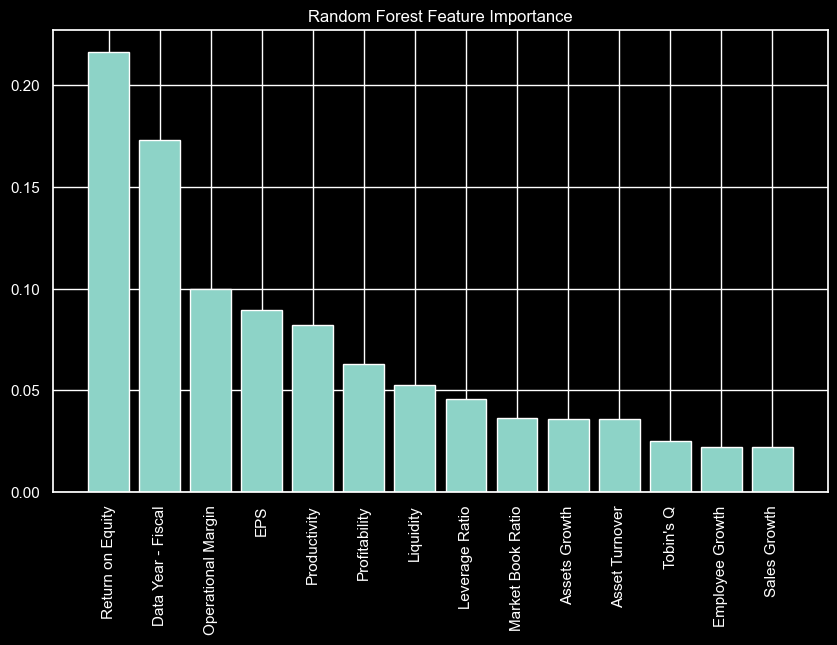

In [77]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(idx)), importances[idx])
plt.xticks(range(len(idx)), X.columns[idx], rotation=90)
plt.title("Random Forest Feature Importance")
plt.show()

### XGBoost Feature Importance

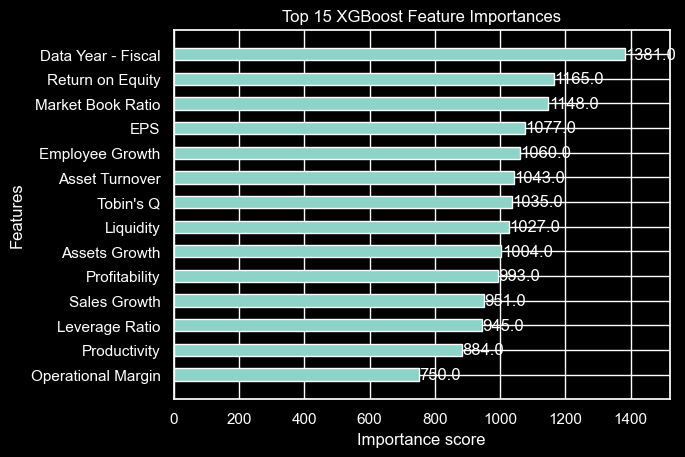

In [78]:
plot_importance(xgb, max_num_features=15, height=0.5)
plt.title("Top 15 XGBoost Feature Importances")
plt.show()

### Learning Curves – Base vs Optimized Models

In [79]:
def plot_learning_curve_comparison(
        model_base,
        model_optimized,
        X,
        y,
        title,
        cv=3
):
    train_sizes, train_scores_base, val_scores_base = learning_curve(
        model_base,
        X,
        y,
        cv=cv,
        scoring="roc_auc",
        n_jobs=N_JOB,
        train_sizes=np.linspace(0.2, 1.0, 3)
    )

    train_sizes, train_scores_opt, val_scores_opt = learning_curve(
        model_optimized,
        X,
        y,
        cv=cv,
        scoring="roc_auc",
        n_jobs=N_JOB,
        train_sizes=np.linspace(0.2, 1.0, 3)
    )

    plt.figure(figsize=(10, 6))

    plt.plot(train_sizes, val_scores_base.mean(axis=1),
             label="Base model", linestyle="--")
    plt.plot(train_sizes, val_scores_opt.mean(axis=1),
             label="Optimized model")

    plt.xlabel("Training Set Size")
    plt.ylabel("ROC AUC")
    plt.title(title)
    plt.legend()

/Users/amaitre/prive/4_ECOLE/S7/programming/lab1/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/amaitre/prive/4_ECOLE/S7/programming/lab1/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


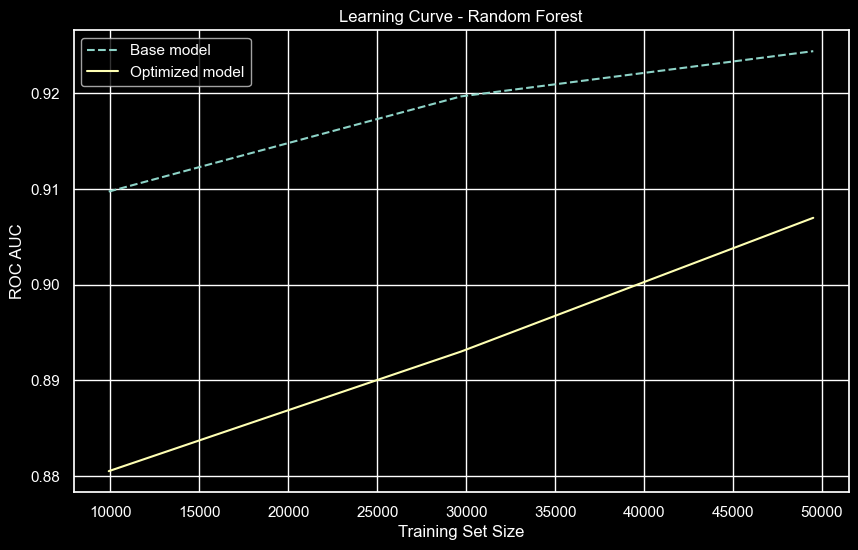

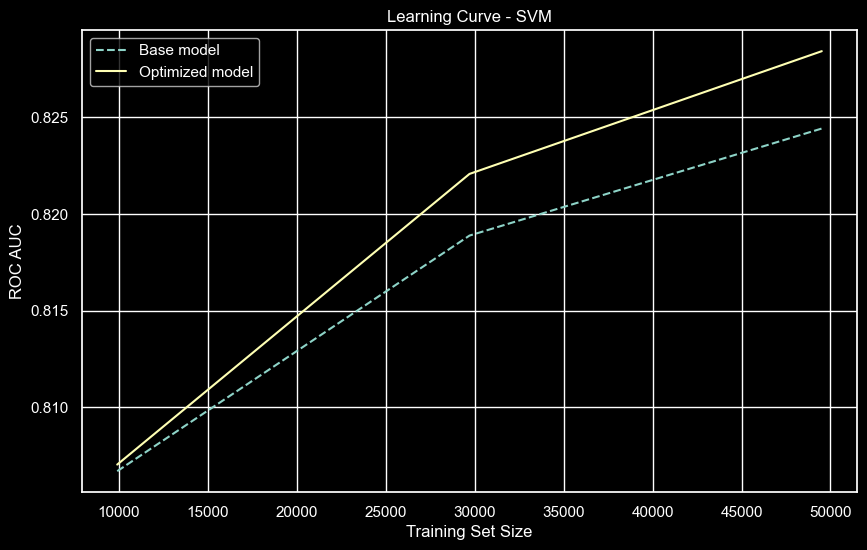

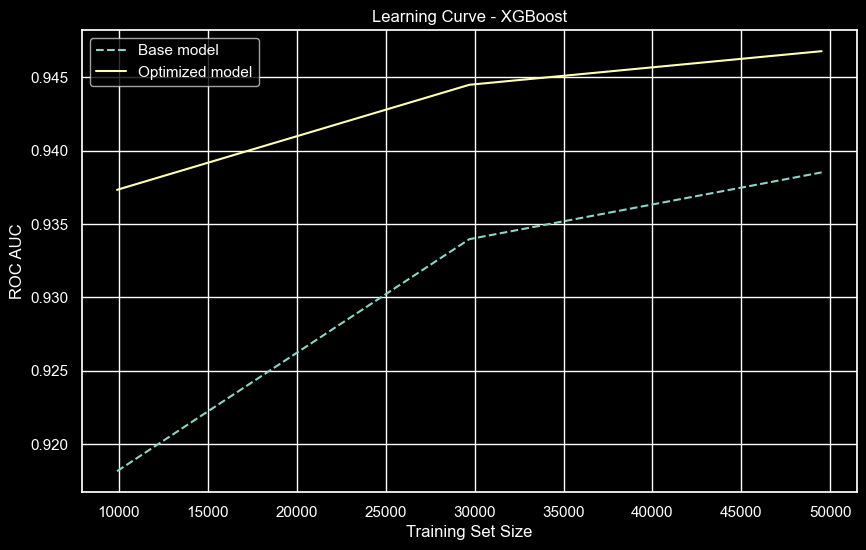

In [80]:
for i in range(3):
    model = [rf, svm_model, xgb][i]
    model_optimized = [rf_optimized, svm_optimized, xgb_optimized][i]
    model_name = ["Random Forest", "SVM", "XGBoost"][i]
    X = X_train if model_name == "XGBoost" else X_train_scaled
    plot_learning_curve_comparison(model, model_optimized, X, y_train, f"Learning Curve - {model_name}")

# 7. Test prediction with mockData

In [81]:
company_data = pd.DataFrame([{
    "Data Year - Fiscal": 2023,
    "Tobin's Q": 1.2,
    "EPS": 0.15,
    "Liquidity": 1.8,
    "Profitability": 0.07,
    "Productivity": 0.9,
    "Leverage Ratio": 0.6,
    "Asset Turnover": 1.3,
    "Operational Margin": 0.12,
    "Return on Equity": 0.10,
    "Market Book Ratio": 2.1,
    "Assets Growth": 0.05,
    "Sales Growth": 0.04,
    "Employee Growth": 0.02
}])

company_data = company_data[X.columns]

In [82]:
company_scaled = scaler.transform(company_data)

In [83]:
rf_pred = rf_optimized.predict(company_scaled)[0]
rf_prob = rf_optimized.predict_proba(company_scaled)[0, 1]

In [84]:
svm_pred = svm_optimized.predict(company_scaled)[0]
svm_prob = svm_optimized.predict_proba(company_scaled)[0, 1]

In [85]:
xgb_pred = xgb_optimized.predict(company_data)[0]
xgb_prob = xgb_optimized.predict_proba(company_data)[0, 1]

In [86]:
prediction_summary = pd.DataFrame({
    "Model": ["Random Forest", "SVM", "XGBoost"],
    "Prediction (0=no, 1=yes)": [rf_pred, svm_pred, xgb_pred],
    "Probability": [rf_prob, svm_prob, xgb_prob]
})

prediction_summary

,Model,"Prediction (0=no, 1=yes)",Probability
0,Random Forest,0,0.000000
1,SVM,0,0.053557
2,XGBoost,0,0.063098


# 8. Final Comparison & Conclusion

### Final Model Comparison Table

In [87]:

optimized_metrics_table = pd.DataFrame([
    compute_metrics(y_test, y_pred_rf_opt, y_prob_rf_opt),
    compute_metrics(y_test, y_pred_svm_opt, y_prob_svm_opt),
    compute_metrics(y_test, y_pred_xgb_opt, y_prob_xgb_opt)
], index=[
    "Random Forest (Optimized)",
    "SVM (Optimized)",
    "XGBoost (Optimized)"
])

In [88]:
optimized_metrics_table

,Accuracy,Precision,Recall,F1-score,ROC AUC
Random Forest (Optimized),0.994614,0.532609,0.875000,0.662162,0.990172
SVM (Optimized),0.775474,0.019882,0.750000,0.038736,0.841363
XGBoost (Optimized),0.902951,0.053383,0.901786,0.100798,0.961457


### Best Model Selection

In [89]:
best_model_name = optimized_metrics_table["ROC AUC"].idxmax()
best_model_score = optimized_metrics_table.loc[best_model_name, "ROC AUC"]
print(f"Best optimized model: {best_model_name}")
print(f"ROC AUC score: {best_model_score:.4f}")

Best optimized model: Random Forest (Optimized)
ROC AUC score: 0.9902
